In [1]:
import os
import random

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 128)
val_labeled_scene_index = np.arange(128, 132)
test_labeled_scene_index = np.arange(132, 134)

In [19]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [20]:
class_label = 1
class_dict = dict()
reverse_class_dict = []
reverse_class_dict.append((-100, -100))
for i in range(400, 800, 50):
    for j in range(100, 600, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))
        
class_dict[(-100, -100)] = 0

In [21]:
class_dict

{(400, 100): 1,
 (400, 150): 2,
 (400, 200): 3,
 (400, 250): 4,
 (400, 300): 5,
 (400, 350): 6,
 (400, 400): 7,
 (400, 450): 8,
 (400, 500): 9,
 (400, 550): 10,
 (450, 100): 11,
 (450, 150): 12,
 (450, 200): 13,
 (450, 250): 14,
 (450, 300): 15,
 (450, 350): 16,
 (450, 400): 17,
 (450, 450): 18,
 (450, 500): 19,
 (450, 550): 20,
 (500, 100): 21,
 (500, 150): 22,
 (500, 200): 23,
 (500, 250): 24,
 (500, 300): 25,
 (500, 350): 26,
 (500, 400): 27,
 (500, 450): 28,
 (500, 500): 29,
 (500, 550): 30,
 (550, 100): 31,
 (550, 150): 32,
 (550, 200): 33,
 (550, 250): 34,
 (550, 300): 35,
 (550, 350): 36,
 (550, 400): 37,
 (550, 450): 38,
 (550, 500): 39,
 (550, 550): 40,
 (600, 100): 41,
 (600, 150): 42,
 (600, 200): 43,
 (600, 250): 44,
 (600, 300): 45,
 (600, 350): 46,
 (600, 400): 47,
 (600, 450): 48,
 (600, 500): 49,
 (600, 550): 50,
 (650, 100): 51,
 (650, 150): 52,
 (650, 200): 53,
 (650, 250): 54,
 (650, 300): 55,
 (650, 350): 56,
 (650, 400): 57,
 (650, 450): 58,
 (650, 500): 59,
 (650,

In [22]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [23]:
def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    for x in batch:
        # input
        front_left_imgs.append(torch.tensor(x[0][0]))
        front_imgs.append(torch.tensor(x[0][1]))
        front_right_imgs.append(torch.tensor(x[0][2]))
        road_imgs.append(torch.tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        bbs.append(bb_tens)
        x_min = 800
        bb_cand = (-100, -100)
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            # We do (800 - top_center_y) because matplotlib y-axis starts from the top. 
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                if top_center_x < x_min:
                    x_min = top_center_x
                    bb_cand = (top_center_x.item(), top_center_y.item())
                    
        target.append(bb_cand)
        # classification logic
#         if int(bb_cand[0]) == -100:
#             target.append((0, bb_cand[0], bb_cand[1]))
#         else:
#             key = (round_down(bb_cand[0]), round_down(bb_cand[1]))
#             if key not in class_dict:
#                 print(bb_cand)
#             label = class_dict[key]
#             target.append((label, bb_cand[0], bb_cand[1]))
                
    boom = torch.stack(front_imgs), torch.tensor(target), torch.stack(road_imgs), bbs, torch.stack(front_right_imgs), torch.stack(front_left_imgs)
    return boom

### Dataset

In [24]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.3, saturation = 0.2, hue = (-0.3, 0.3)),
        transforms.Grayscale(3),
        transforms.RandomAffine(10),
    ]),
    transforms.ToTensor(),
])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=48, shuffle=True, collate_fn=front_collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=48, shuffle=False, collate_fn=front_collate_fn)


In [93]:
sample, target, road_img, bbs, front_right, front_left = iter(train_loader).next()

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

In [94]:
idx = 0

In [95]:
target

tensor([[ 577.6689,  326.1908],
        [ 530.1570,  366.4467],
        [ 631.8262,  367.0338],
        [ 599.0632,  318.9580],
        [ 489.2426,  363.1800],
        [ 578.1846,  366.1415],
        [-100.0000, -100.0000],
        [ 549.0831,  364.6653],
        [ 562.5258,  364.7414],
        [ 510.6919,  433.7326],
        [ 570.0146,  365.0349],
        [ 598.2483,  324.6366],
        [ 531.2910,  365.3252],
        [ 783.9816,  176.7348],
        [ 585.0981,  440.5469],
        [ 456.4213,  432.7658],
        [ 471.0905,  432.0860],
        [ 518.2539,  431.9480],
        [ 663.7520,  356.9786],
        [ 774.0092,  370.2171],
        [-100.0000, -100.0000],
        [ 516.6536,  436.9645],
        [ 545.2736,  489.8173],
        [-100.0000, -100.0000],
        [-100.0000, -100.0000],
        [ 476.2182,  431.8950],
        [ 566.8483,  364.2920],
        [ 597.6796,  366.2632],
        [-100.0000, -100.0000],
        [ 551.2949,  364.1500],
        [ 549.1967,  475.1152],
        

In [98]:
preds = model(sample.to(device))
preds

tensor([[8.2677, 7.5749],
        [8.1612, 7.5384],
        [8.1836, 7.5777],
        [8.1918, 7.5879],
        [8.1953, 7.4941],
        [8.1075, 7.4651],
        [8.1504, 7.4663],
        [8.2296, 7.4704],
        [8.1711, 7.4315],
        [8.2218, 7.4965],
        [8.2500, 7.3270],
        [8.0645, 7.5369],
        [8.1006, 7.4374],
        [8.2311, 7.4941],
        [8.1858, 7.4596],
        [8.2388, 7.4987],
        [8.1854, 7.5163],
        [8.3449, 7.5003],
        [8.2010, 7.5243],
        [8.1628, 7.6277],
        [8.2207, 7.4304],
        [8.1872, 7.5604],
        [8.1384, 7.5843],
        [8.2876, 7.5399],
        [8.1957, 7.5894],
        [8.2360, 7.4430],
        [8.1979, 7.6191],
        [8.2883, 7.4589],
        [8.1856, 7.6051],
        [8.1353, 7.5206],
        [8.2604, 7.4877],
        [8.1319, 7.6230],
        [8.2075, 7.5643],
        [8.2393, 7.5489],
        [8.1289, 7.4472],
        [8.1675, 7.7211],
        [8.1844, 7.5798],
        [8.1737, 7.4910],
        [8.1

In [101]:
idx += 1

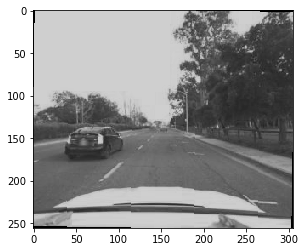

In [102]:
plt.imshow(sample[idx].cpu().detach().numpy().transpose(1, 2, 0))

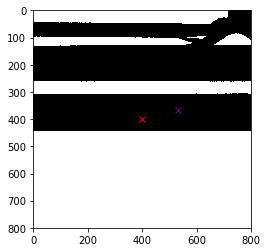

In [103]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="purple")
# ax.plot(model_preds[idx][0].cpu().detach().numpy()*100, model_preds[idx][1].cpu().detach().numpy()*100, 'x', color="green")


In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        
#         self.classification = nn.Sequential(OrderedDict([
#             ('linear1', nn.Linear(512, 81)),
#         ]))
        
        self.regression = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 2)),
        ]))
        
#         self.regression.linear1.bias = nn.Parameter(torch.tensor(8.))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.regression(x)
    
model = SimpleModel().to(device)

### Train/Val

In [112]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
best_val_loss = 100

In [113]:
def train():
    model.train()
    train_losses = []
    for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(train_loader):

        optimizer.zero_grad()

        sample = sample.to(device)
        target = target.to(device)
        
        y_hat = model(sample)
        target /= 100.
#         target = target[:, 0]
        loss = criterion(y_hat, target)
        
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                10. * i / len(train_loader), loss.item()))
            
    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
            
def val():
    model.eval()
    val_losses = []
    for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(val_loader):

        model.eval()

        sample = sample.to(device)
        target = target.to(device)

        with torch.no_grad():
            target /= 100.
            target = target[:, :2]
            # target = target[:, 0]
            y_hat = model(sample)
            loss = criterion(y_hat, target)

            val_losses.append(loss.item())

#         if i % 5 == 0:
#             print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
#                 epoch, i * len(sample), len(val_loader.dataset),
#                 5. * i / len(val_loader), np.mean(val_losses)))
            
    print("Average Validation Epoch Loss: ", np.mean(val_losses))
    global best_val_loss
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(model.state_dict(), 'best_val_loss_simple_class_then_reg.pt')

In [114]:
# model = SimpleModel().to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [115]:
# logs,losses = find_lr(model, criterion, optimizer)

In [116]:
model = SimpleModel().to(device)
# model_dict = model.state_dict()
# pretrained_dict = torch.load('best_val_loss_simple.pt')
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# model_dict.update(pretrained_dict) 
# model.load_state_dict(model_dict)

# for name, param in model.encoder.named_parameters():
#     if("bn" not in name):
#         param.requires_grad = False
        
# unfreeze_layers = [model.encoder.layer3, model.encoder.layer4]
# for layer in unfreeze_layers:
#     for param in layer.parameters():
#         param.requires_grad = True
        


In [117]:
# found_lr = 3e-4
# optimizer = torch.optim.Adam([
# { 'params': model.encoder.layer4.parameters(), 'lr': found_lr /3},
# { 'params': model.encoder.layer3.parameters(), 'lr': found_lr /9},
# ], lr=3e-4)

In [118]:
epochs = 40
for epoch in range(epochs):
    train()
    val()

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

Train Epoch: 0 [0/2772 (0%)]	Loss: 16.580915
Train Epoch: 0 [480/2772 (2%)]	Loss: 16.949387
Train Epoch: 0 [960/2772 (3%)]	Loss: 15.377954
Train Epoch: 0 [1440/2772 (5%)]	Loss: 16.209654
Train Epoch: 0 [1920/2772 (7%)]	Loss: 14.743741
Train Epoch: 0 [2400/2772 (9%)]	Loss: 16.279917

Average Train Epoch Loss:  15.960519757764093
Average Validation Epoch Loss:  19.472525336525656
Train Epoch: 1 [0/2772 (0%)]	Loss: 15.696876
Train Epoch: 1 [480/2772 (2%)]	Loss: 14.468944
Train Epoch: 1 [960/2772 (3%)]	Loss: 15.651337
Train Epoch: 1 [1440/2772 (5%)]	Loss: 14.391258
Train Epoch: 1 [1920/2772 (7%)]	Loss: 17.656601
Train Epoch: 1 [2400/2772 (9%)]	Loss: 18.279699

Average Train Epoch Loss:  15.95686075605195
Average Validation Epoch Loss:  18.624528711492363
Train Epoch: 2 [0/2772 (0%)]	Loss: 15.921196
Train Epoch: 2 [480/2772 (2%)]	Loss: 14.498886
Train Epoch: 2 [960/2772 (3%)]	Loss: 16.603607
Train Epoch: 2 [1440/2772 (5%)]	Loss: 16.511362
Train Epoch: 2 [1920/2772 (7%)]	Loss: 17.816572
Trai

Average Validation Epoch Loss:  18.645024993202902
Train Epoch: 22 [0/2772 (0%)]	Loss: 14.692917
Train Epoch: 22 [480/2772 (2%)]	Loss: 15.256068
Train Epoch: 22 [960/2772 (3%)]	Loss: 16.788935
Train Epoch: 22 [1440/2772 (5%)]	Loss: 15.845744


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('best_val_loss_simple.pt', map_location=device))

val_losses = []
for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(val_loader):
    
    model.eval()
    
    sample = sample.to(device)
    target = target.to(device)
    
    with torch.no_grad():
        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = criterion(y_hat, target)
        
        val_losses.append(loss.item())
    
    if i % 5 == 0:
        print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
            0, i * len(sample), len(val_loader.dataset),
            5. * i / len(val_loader), np.mean(val_losses)))

In [38]:
labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size=32, shuffle=False, collate_fn=front_collate_fn)

In [ ]:
model.load_state_dict(torch.load('best_val_loss_simple.pt'))

test_losses = []
for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(test_loader):
    
    model.eval()
    
    sample = sample.to(device)
    target = target.to(device)
    
    with torch.no_grad():
        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = criterion(y_hat, target)
        
        test_losses.append(loss.item())
    
print("Average Test Loss: ", np.mean(test_losses))

In [39]:
test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)

In [40]:
sample, target, road_img, bbs, front_right, front_left = iter(test_loader).next()
sample = sample.to(device)
model_preds = model(sample)

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

In [ ]:
model_preds

In [42]:
idx = 5

In [43]:
idx += 1

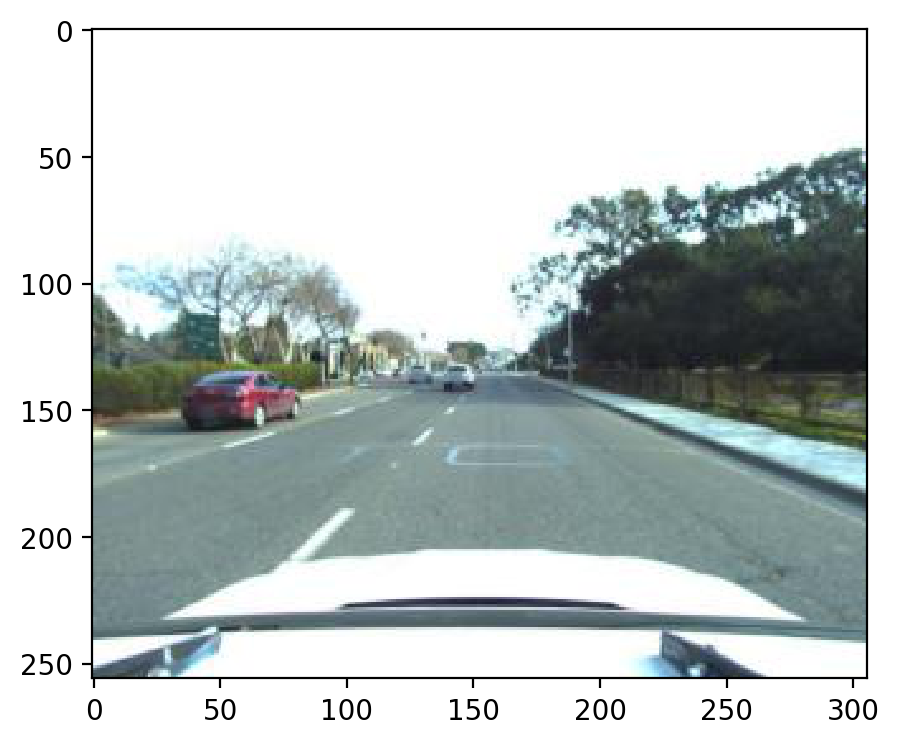

In [44]:
plt.imshow(sample[idx].cpu().detach().numpy().transpose(1, 2, 0))

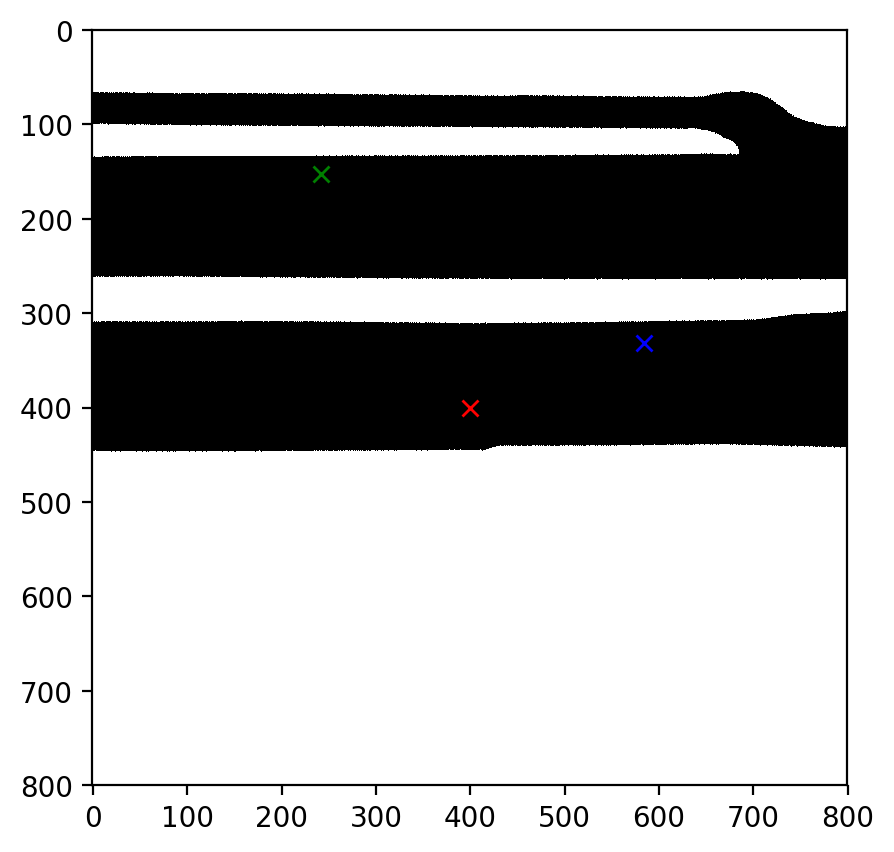

In [45]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="blue")
ax.plot(model_preds[idx][0].cpu().detach().numpy()*100, model_preds[idx][1].cpu().detach().numpy()*100, 'x', color="green")


In [ ]:
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=20, shuffle=True, collate_fn=front_collate_fn)
sample, target, road_img, bbs, front_right, front_left = iter(val_loader).next()
sample = sample.to(device)
target = target.to(device)
model.eval()
target/100.

In [ ]:
model(sample)

In [ ]:
sample, target, road_img, bbs, front_right, front_left = iter(train_loader).next()

In [ ]:
sample.shape

In [ ]:
target

In [ ]:
idx = 0
plt.imshow(sample[idx][:, :, :].numpy().transpose(1, 2, 0))
# plt.imshow(front_right[idx][:, :, :].numpy().transpose(1, 2, 0))

In [ ]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="blue")